# Supervised Topic modelling :


This is a multi-class classification problem. 

- input data : the post (title and content)
- labels : associated tags  

We downloaded tags that correspond to each stackOverflow post, so we can train supervised model to handle this.
The number of classes outputs is the number of different label present in the label corpus.

**Preprocessing** :


To avoid the curse of dimensionality issue (as our word corpus is very large) we will use prior LSA and word-embedding representation technique.


**Model Benchmark**

- Logistic regression : one-vs-rest
- SVM 
- Random forest 
- NN with prior embeddings : in the second supervised notebook
with three different prior embeddings : Word2VEc, BERT and USE

All the models will be compared and selected upon the **average_precision_scores** and	**jaccard_scores**.

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from  tm_common import * 
IN_COLAB, output_dir = tm_get_working_config()

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# word count
import gensim
import gensim.corpora as corpora
from gensim.models import Word2Vec

from scipy.sparse import csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import jaccard_score, average_precision_score


In [4]:
sto_corpus = np.load(f"{output_dir}corpus.npy",allow_pickle=True)
sto_corpus_tags = np.load(f"{output_dir}corpus_tags.npy",allow_pickle=True)

sto_titles = np.load(f"{output_dir}bag_of_words_titles.npy",allow_pickle=True)
sto_body = np.load(f"{output_dir}bag_of_words_body.npy",allow_pickle=True)

# Balanced or representative dataset  ?

In [5]:
NB_DOCS = 5000
sto_corpus = sto_corpus[:NB_DOCS]
sto_titles = sto_titles[:NB_DOCS]
sto_body = sto_body[:NB_DOCS]
sto_corpus_tags = sto_corpus_tags[:NB_DOCS]

# sto_corpus = sto_corpus
# sto_titles = sto_titles
# sto_body = sto_body
# sto_corpus_tags = sto_corpus_tags

## Number of classes
I want to focus on main tags, therefore thanks to the graphic above I selected **30 tags**.


In [9]:
labels = tags_series.value_counts().head(30)
labels

c#                785
java              733
c++               657
javascript        580
python            544
android           407
ios               407
.net              344
c                 306
php               279
html              244
performance       213
jquery            212
objective-c       190
css               169
algorithm         166
asp.net           160
linux             159
sql               152
c++11             151
node.js           146
swift             136
mysql             132
windows           131
spring            130
multithreading    128
iphone            128
arrays            113
json              113
xcode              97
Name: count, dtype: int64

In [10]:
# each label is associated to an id between 0 and 29 by a dictionary
label_list = np.array(labels.index)
d = dict(zip(label_list, range(0,len(label_list))))

# The Multi-Label classification :

Multi-label classification is different form Multi-label classification.  In multi-class classification, each instance belong to a specific label, in multi-class classification, a instance may belong to 0 or multiple class.

Here, each instance of our dataset has multiple labels. The prediction is therefore mutually non-exclusive.
We need a model that can predict zero or more class.

In [11]:
# multi-label classification
def retrieve_tag_in_selected_list(tags_list, selection_list):
  tags_list_selection = []
  for tags in tags_list:
    tmp = [ d[tag] for tag in tags if tag in selection_list  ]
    tags_list_selection.append( tmp )
  return tags_list_selection

Y_n = retrieve_tag_in_selected_list(sto_corpus_tags, labels)


In [12]:
Y_n[:10]

[[4, 15], [8, 27], [3, 9], [1], [3, 9], [6], [0, 7, 2], [23], [2, 8], [18]]

## X_train, X_test, Y_train, Y_test slip

This is done before tfidf to avoid data leakage

In [13]:
(
    X_corpus_train,
    X_corpus_test,
    X_title_train,
    X_title_test,
    X_body_train,
    X_body_test,
    y_train,
    y_test,
) = train_test_split(sto_corpus, sto_titles, sto_body, Y_n, test_size=0.2, random_state=1)

In [14]:
np.save(f"{output_dir}X_corpus_train.npy",X_corpus_train,   allow_pickle=True)
np.save(f"{output_dir}X_corpus_test.npy", X_corpus_test,   allow_pickle=True)

np.save(f"{output_dir}X_title_train.npy", X_title_train, allow_pickle=True)
np.save(f"{output_dir}X_title_test.npy",  X_title_test, allow_pickle=True)

np.save(f"{output_dir}X_body_train.npy",X_body_train,   allow_pickle=True)
np.save(f"{output_dir}X_body_test.npy", X_body_test,   allow_pickle=True)

np.save(f"{output_dir}y_train.npy",       y_train, allow_pickle=True)
np.save(f"{output_dir}y_test.npy",        y_test,   allow_pickle=True)
np.save(f"{output_dir}label_list.npy",    label_list,   allow_pickle=True)


c:\dev\topic_modelling\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [15]:
print( len(X_title_train) )
print( len(X_corpus_train) )
print( len(X_title_test) )
print( len(y_test)       )

4000
4000
1000
1000


In [16]:
y_test[:5]

[[1], [5], [21], [0, 7], [2]]

# Label preprocessing : 


In [17]:
mlb = MultiLabelBinarizer()
y_train_b = mlb.fit_transform(y_train)
y_test_b = mlb.transform(y_test)

[ True Negative , false positive] ,
[False negative, true positivve ]

## Handling body and title :
- simple concatenation 
- only body 
- only title
- more weights apply to title

In [24]:
# simple concatenation
X_train = [
    np.append(X_title_train[i], X_body_train[i]) for i in range(len(X_title_train))
]
X_test = [np.append(X_title_test[i], X_body_test[i]) for i in range(len(X_title_test))]

X_train_biased_towards_title = [
    np.concatenate((np.repeat(X_title_train[i], 5), X_body_train[i]))
    for i in range(len(X_title_train))
]
X_test_biased_towards_title = [
    np.concatenate((np.repeat(X_title_train[i], 5), X_body_test[i]))
    for i in range(len(X_title_test))
]

# Dummy classifier 

In [26]:
dummy_clf = MultiOutputClassifier(DummyClassifier(strategy="most_frequent"))
dummy_clf.fit(X_train, y_train_b)
y_pred = dummy_clf.predict(X_test) 
precision_dummy = average_precision_score(y_test_b, y_pred, average="micro")
jaccard_score_dummy = jaccard_score(y_test_b, y_pred, average="micro")

# Logistic regression : One VS Rest

In [27]:
def logistic_reg_train(X_train_svd, y_train_b):
    model = MultiOutputClassifier(LogisticRegression(multi_class="ovr"))
    model.fit(X_train_svd, y_train_b)
    return model


def plot_counf_matrix(y_test, y_pred, NB_LABEL=4):
    fig, axs = plt.subplots(1, NB_LABEL, figsize=(NB_LABEL * 5, 5))
    for i in range(NB_LABEL):
        rdm_label = i * 5
        cm = multilabel_confusion_matrix(y_test, y_pred)[rdm_label]

        display_labels = ["others", label_list[rdm_label]]
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=display_labels
        )
        disp.plot(ax=axs[i], colorbar=False)

    plt.show()

## Evaluation :    
average precision : summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold
jaccard similarity coefficient  : size of intersection divided by the size of the union

micro : to calculate the metric globally as it is multi-label case

In [25]:
def get_logistic_score(X_train, X_test, return_yhat=False):
    X_svd_train, X_svd_test = tfidf_lsa_preprocessing(X_train, X_test)
    model = logistic_reg_train(X_svd_train, y_train_b)
    yhat = model.predict(X_svd_test)
    precision_logistic = average_precision_score(y_test_b, yhat, average="micro")
    jaccard_score_logistic = jaccard_score(y_test_b, yhat, average="micro")
    if return_yhat:
        return precision_logistic, jaccard_score_logistic, yhat
    return precision_logistic, jaccard_score_logistic


precision_logistic_body_only, jaccard_score_logistic_body_only = get_logistic_score(
    X_body_train, X_body_test
)
precision_logistic_title_only, jaccard_score_logistic_title_only = get_logistic_score(
    X_title_train, X_title_test
)
precision_logistic_concatenation, jaccard_score_logistic_concatenation= get_logistic_score(X_train, X_test)

In [30]:
precision_logistic_biased, jaccard_score_logistic_biased = get_logistic_score(X_train_biased_towards_title, X_test_biased_towards_title)

In [31]:
avg_precision_scores = [
    precision_logistic_body_only,
    precision_logistic_title_only,
    precision_logistic_concatenation,
    precision_logistic_biased,

]
jaccard_scores = [
    jaccard_score_logistic_body_only,
    jaccard_score_logistic_title_only,
    jaccard_score_logistic_concatenation,
    jaccard_score_logistic_biased,
]

result = pd.DataFrame(
    {
        "average_precision_scores": avg_precision_scores,
        "jaccard_scores": jaccard_scores,
    },
    index=[
        "logistic : body only",
        "logistic : title only",
        "logistic : concatenation",
        "logistic : biased towards title",
    ],
)
result

,average_precision_scores,jaccard_scores
logistic : body only,0.131073,0.089329
logistic : title only,0.134034,0.088554
logistic : concatenation,0.139004,0.097722
logistic : biased towards title,0.078979,0.038599


Concatenation of body and title and titles only achieve better scores than body only and biased input. This might be explained as logistic regression is a simple model and titles carry less information and might be more separable than concatenation. 

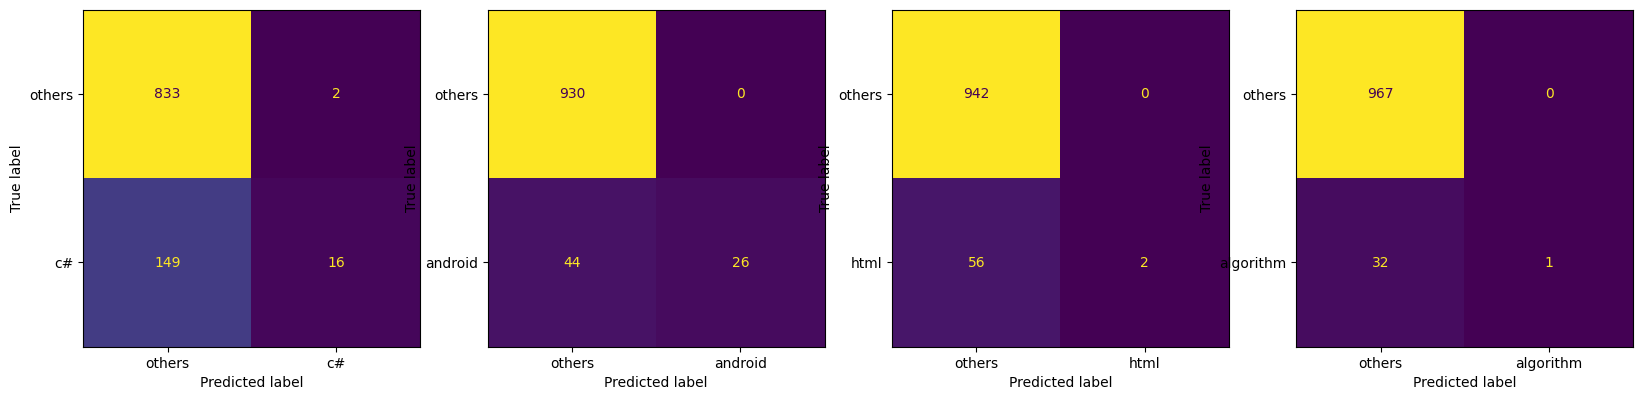

In [32]:
_, _, yhat=  get_logistic_score( X_title_train, X_title_test, return_yhat=True)
plot_counf_matrix(y_test_b, yhat)

## SVM : Support Vector Classification (SVC) one vs one

In [33]:
# test title only at input
def get_svm_score(X_train, X_test):
    X_svd_train, X_svd_test = tfidf_lsa_preprocessing(X_train, X_test)
    regressor = MultiOutputClassifier(
        svm.SVC(decision_function_shape="ovo", kernel="rbf")
    )
    regressor.fit(X_svd_train, y_train_b)
    y_pred = regressor.predict(X_svd_test)
    precision_svm = average_precision_score(y_test_b, y_pred, average="micro")
    jaccard_score_svm = jaccard_score(y_test_b, y_pred, average="micro")

    return precision_svm, jaccard_score_svm, y_pred


precision_svm_title_only, jaccard_score_svm_title_only, y_pre_title_only = get_svm_score(X_title_train, X_title_test)

In [34]:
# test concatenation 
precision_svm, jaccard_score_svm, y_pred_concat = get_svm_score(X_train, X_test)

In [35]:
avg_precision_scores = [precision_svm_title_only,precision_svm]
jaccard_scores = [jaccard_score_svm_title_only,jaccard_score_svm ]
result = pd.DataFrame(
    {
        "average_precision_scores": avg_precision_scores,
        "jaccard_scores": jaccard_scores,
    },
    index=[
        "SVM : title only ",
        "SVM : concatenation ",
    ],
)
result

,average_precision_scores,jaccard_scores
SVM : title only,0.226412,0.202472
SVM : concatenation,0.373852,0.382614


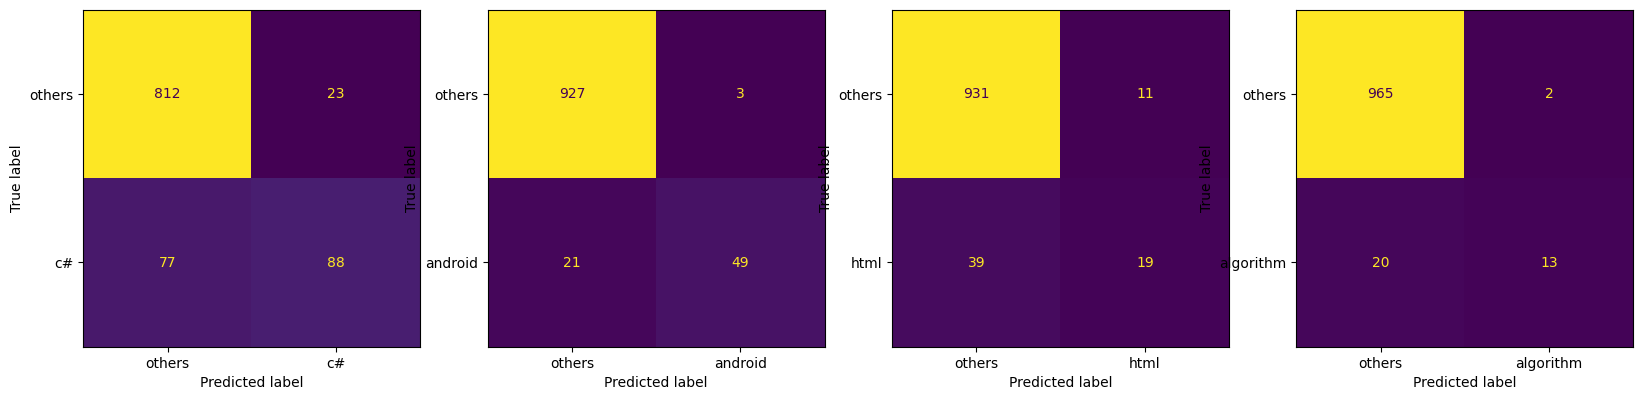

In [36]:
plot_counf_matrix(y_test_b, y_pred_concat)

# Random forest

## Consecutive grid-search for hyperparameters tunning :

In [37]:
X_svd_train, X_svd_test = tfidf_lsa_preprocessing(X_train, X_test)

The hyper-parameter tunning is very long to run. I choose to compute it for a subset. 

If the model is the one achieving the best performance then I will tune it on the all train set. 

In [43]:
n_estimators = [20, 50]  # number of trees in the random forest
max_depth = [2 ,5, 10]  # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10]  # minimum sample number to split a node
min_samples_leaf = [1, 3, 4]  # minimum sample number that can be stored in a leaf node

random_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
}

rf = RandomForestRegressor()
grid_seach_rf = GridSearchCV(rf, random_grid)  #  default 5-fold cross validation,

grid_seach_rf.fit(X_svd_train[:300], y_train_b[:300])

print("Random grid: ", grid_seach_rf, "\n")
print("Best Parameters: ", grid_seach_rf.best_params_, " \n")

Random grid:  GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5, 10], 'min_samples_leaf': [1, 3, 4],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [20, 50]}) 

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}  



In [46]:
best_params = grid_seach_rf.best_params_
RF_MAX_DEPTH = best_params.get('max_depth')
RF_N  = best_params.get('n_estimators')
RF_MIN_SAMPLE_LEAF =  best_params.get('min_samples_leaf')
RF_MIN_SAMPLES_SPLIT= best_params.get('min_samples_split')

In [47]:
rf = RandomForestRegressor(oob_score=True,
                        min_samples_leaf=RF_MIN_SAMPLE_LEAF, 
                        min_samples_split=RF_MIN_SAMPLES_SPLIT,
                        n_estimators=RF_N,
                        max_depth=RF_MAX_DEPTH)
rf.fit(X_svd_train, y_train_b)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=50,
                      oob_score=True)

In [51]:
y_train_pred = rf.predict(X_svd_train)
threshold_test = tm_test_threshold(y_train_b, y_train_pred)  

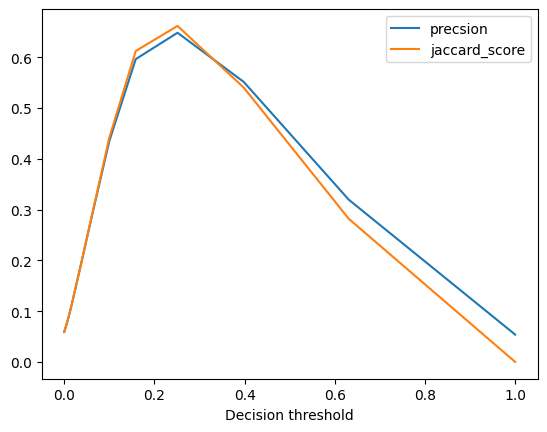

In [52]:
tm_plot_threshold_test(threshold_test)

In [53]:
max_config = threshold_test.query('precision == precision.max()')
t = max_config["threshold"]
best_t =  t.values[0]
best_t

0.25118864315094075

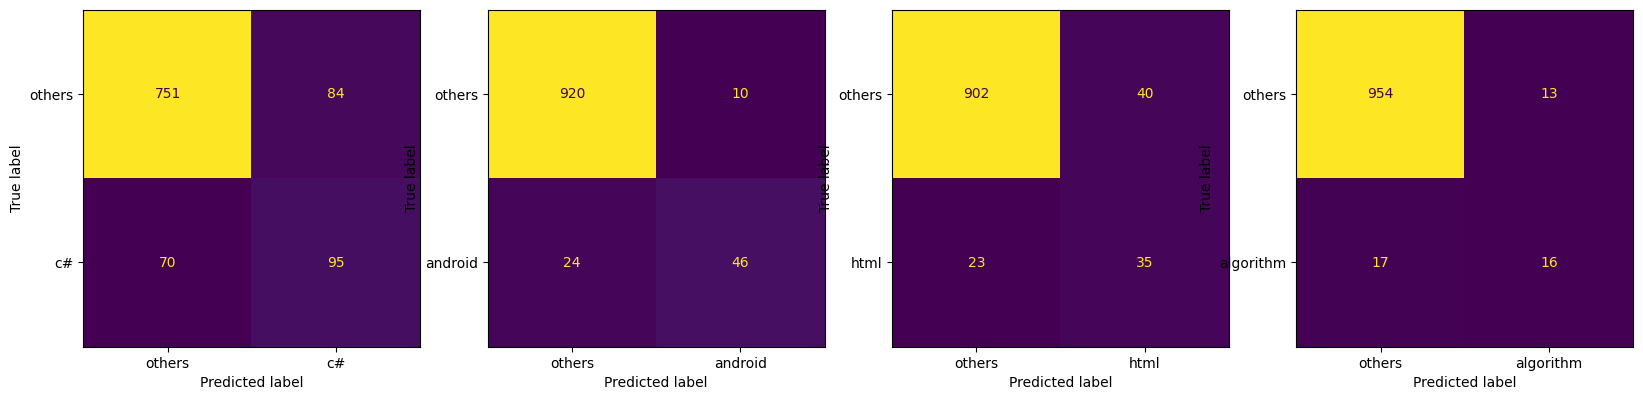

In [54]:
y_pred_rf = rf.predict(X_svd_test)
y_pred_rf = (y_pred_rf > best_t).astype(np.float32)
plot_counf_matrix(y_test_b, y_pred_rf)

In [55]:
precision_rf      = average_precision_score(y_test_b, y_pred_rf, average='micro')
jaccard_score_rf = jaccard_score(y_test_b, y_pred_rf, average='micro')

## Evaluation 

In [57]:
avg_precision_scores = [
    precision_dummy,
    precision_logistic_concatenation,
    precision_svm,
    precision_rf,
]
jaccard_scores = [
    jaccard_score_dummy,
    jaccard_score_logistic_concatenation,
    jaccard_score_svm,
    jaccard_score_rf,
]

result = pd.DataFrame(
    {
        "average_precision_scores": avg_precision_scores,
        "jaccard_scores": jaccard_scores,
    },
    index=[
        "Dummy classifier",
        "logistic : concatenation",
        "SVM : concatenation ",
        "RandomForest",
    ],
)
result.to_csv(f"{output_dir}result_supervised1.csv")

ValueError: Length of values (4) does not match length of index (3)

In [ ]:
result

,average_precision_scores,jaccard_scores
logistic : title only,0.079976,0.042445
SVM : concatenation,0.192487,0.178512
RandomForest,0.223417,0.284742
